In [46]:
import torchvision.transforms as T
import torchvision.transforms.functional as F
import torchvision
import os

from model.decoder import Decoder
from options import HiDDenConfiguration
import torch

import numpy as np
from utils import ImageFolderInstance
from average_meter import AverageMeter
from collections import defaultdict
from typing import Any, BinaryIO, List, Optional, Tuple, Union
from tqdm import tqdm
from noise_layers.crop import Test_Crop
import argparse
import matplotlib.pyplot as plt
from noise_layers.jpeg_compression import *
from PIL import Image

In [47]:
wm_checkpoint_path='/tmp2/jimmyliu/HiDDeN_experiment/wm_decoder_checkpoint/combined-baseline-256-adam-mse--epoch-104.pyt'
whitening_layer_path='/tmp2/jimmyliu/HiDDeN_experiment/wm_decoder_checkpoint/first_104.pt'
folder_path='/tmp2/jimmyliu/HiDDeN_experiment/gen_images/noise_w'

batch_size=1
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

fix_message=torch.Tensor([1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,                                                                                                                                                                                                   
        1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,                                                                                                                                                                                                                 
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.])
message=fix_message.repeat(batch_size,1).to(device)




hidden_config = HiDDenConfiguration(H=512, W=512,
                                            message_length=48,
                                            encoder_blocks=4, encoder_channels=64,
                                            decoder_blocks=7, decoder_channels=64,
                                            use_discriminator=True,
                                            use_vgg=False,
                                            discriminator_blocks=3, discriminator_channels=64,
                                            decoder_loss=1,
                                            encoder_loss=0.2,
                                            adversarial_loss=1e-3,
                                            enable_fp16=False,
                                            alpha=0.3,
                                            loss_type='mse',
                                            opt_type='adam',
                                            data_len=5000,
                                            accu_step=1
                                            )

wm_decoder=Decoder(hidden_config)
wm_checkpoint=torch.load(wm_checkpoint_path)
decoder_dict=wm_decoder.state_dict()
pretrained_dict = {k[8:]: v for k, v in wm_checkpoint['enc-dec-model'].items() if (k[8:] in decoder_dict and 'encoder' not in k)}
wm_decoder.load_state_dict(pretrained_dict)
wm_decoder=wm_decoder.to(device)

whitening_layer=torch.load(whitening_layer_path).to(device)
whitening_layer.eval()

crop_size=500
def brightness(img):
    # Convert the image to PIL format if it's not already
    if not isinstance(img, Image.Image):
        img = T.ToPILImage()(img)

    # Apply the brightness adjustment
    img = T.functional.adjust_brightness(img, brightness_factor=2.0)  # Adjust the brightness factor as desired

    return img

noise_transform=brightness
open_transform=T.Compose([
        #T.CenterCrop(size=crop_size),
        #T.Pad(int((512-crop_size)/2), 0),
        noise_transform,
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])


dataset=torchvision.datasets.ImageFolder(folder_path,open_transform)

data_loader=torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=False, num_workers=4)

#validation_losses = defaultdict(AverageMeter)

acc_list=[]
wm_decoder.eval()
crop=Test_Crop((0.35,0.35),(0.35,0.35))



  0%|          | 0/5000 [00:00<?, ?it/s]

tensor([[[[0.5882, 0.4392, 0.4078,  ..., 0.5255, 0.6275, 0.6510],
          [0.4157, 0.3059, 0.2745,  ..., 0.5255, 0.5412, 0.5333],
          [0.3529, 0.2588, 0.3451,  ..., 0.4549, 0.5961, 0.5569],
          ...,
          [0.6039, 0.5882, 0.5490,  ..., 0.5333, 0.4863, 0.5490],
          [0.5961, 0.6118, 0.4627,  ..., 0.4784, 0.5255, 0.5882],
          [0.7137, 0.6196, 0.5490,  ..., 0.5176, 0.5804, 0.6824]],

         [[0.5569, 0.3843, 0.3451,  ..., 0.5098, 0.5804, 0.6431],
          [0.4314, 0.3216, 0.2902,  ..., 0.5176, 0.5333, 0.5490],
          [0.3922, 0.2902, 0.3608,  ..., 0.4706, 0.5961, 0.5725],
          ...,
          [0.6667, 0.6588, 0.6353,  ..., 0.6118, 0.5412, 0.6196],
          [0.6431, 0.6667, 0.5490,  ..., 0.5490, 0.5961, 0.6510],
          [0.7216, 0.6588, 0.6039,  ..., 0.5725, 0.6275, 0.6980]],

         [[0.5020, 0.3451, 0.3216,  ..., 0.5098, 0.5961, 0.6275],
          [0.3686, 0.2980, 0.2980,  ..., 0.5412, 0.5490, 0.5490],
          [0.3451, 0.3294, 0.4784,  ..., 0

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:10                                                                             │
│                                                                                                  │
│    7 │   │   image=image/2.+0.5                                                                  │
│    8 │   │   print(image)                                                                        │
│    9 │   │   plt.imshow(image[0].cpu().numpy().transpose(1,2,0))                                 │
│ ❱ 10 │   │   raise NotImplementedError                                                           │
│   11 │   │                                                                                       │
│   12 │   │   decoded_messages=wm_decoder(temp)                                                   │
│   13 │   │   decoded_messages=whitening_layer(decoded_messages)                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NotImplementedError

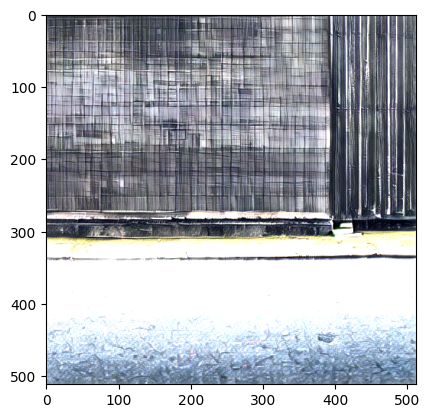

In [48]:
with torch.no_grad():
    for image, _ in tqdm(data_loader):
        image = image.to(device)

        
        #image=(image+1.)/2.
        image=image/2.+0.5
        print(image)
        plt.imshow(image[0].cpu().numpy().transpose(1,2,0))
        raise NotImplementedError
        
        decoded_messages=wm_decoder(temp)
        decoded_messages=whitening_layer(decoded_messages)
       

        decoded_rounded = decoded_messages.detach().cpu().numpy().round().clip(0, 1)
        bitwise_avg_err = np.sum(np.abs(decoded_rounded - message.detach().cpu().numpy())) / (batch_size * message.shape[1])

        acc_list.append(bitwise_avg_err)


np_acc=np.array(acc_list)
print(np_acc.mean())